# Reconocimiento de dígitos con KNN

Veamos como interactuar con las clases implementadas en el módulo de C++ haciendo una experimentación muy simplificada, y a modo de ejemplo, del método KNN para reconocer digitos

## Compilando el módulo desde C++

Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [47]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: build: File exists
-- The C compiler identification is AppleClang 13.0.0.13000029
-- The CXX compiler identification is AppleClang 13.0.0.13000029
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /Users/fcastagna/opt/miniconda3/envs/metnum-tp2/bin/python (found version "3.9.7") 
-- Found PythonLibs: /Users/fcastagna/opt/miniconda3/envs/metnum-tp2/lib/libpython3.9.dylib
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/Users/fcastagna/facu/metodos-tp-2

In [14]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/Users/fcastagna/facu/metodos-tp-2/metodos-tp2/notebooks
Python 3.9.7


## Explorando los datos

In [15]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Es un csv, con columnas por cada pixel

In [16]:
df_train[:10]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
4    0.0954
8    0.0954
5    0.0938
Name: label, dtype: float64

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [43]:
# Ir variando la cantidad de datos, y ver como aumenta la precisión


df_train = df_train[:5000]


En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [44]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 7


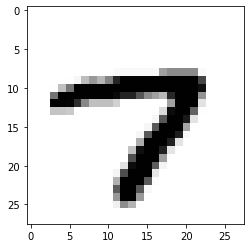

In [45]:
import matplotlib.pyplot as plt

num = 1917

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [46]:
df_train["label"].value_counts(normalize=True)


1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
4    0.0954
8    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [21]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score

# Acá pueden cambiar el clasificador nuestro por el de sklearn!

def knn_pca_exp(k,c,X_train,X_val,y_train,y_val):
    
    if (c >= 0):
        pca = metnum.PCA(c)

        pca.fit(X_train)
        X_train = pca.transform(X_train);
        X_val = pca.transform(X_val)

    clf = metnum.KNNClassifier(k)
    clf.fit(X_train, y_train)
        
    # %%time
    
    y_pred = clf.predict(X_val)
    
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred, average='macro')
    prec = precision_score(y_val, y_pred, average='macro')

    print("Accuracy: {}".format(acc))
    print("Recall: {}".format(rec))
    print("Precision: {}".format(prec))
    return acc


In [34]:
knn_pca_exp(8,-1,X_train,X_val,y_train,y_val)


Accuracy: 0.931
Recall: 0.9296397426016008
Precision: 0.9338111118080121


0.931

Accuracy: 0.93
Accuracy: 0.916
Accuracy: 0.926
Accuracy: 0.922
Accuracy: 0.928
Accuracy: 0.929
Accuracy: 0.926
Accuracy: 0.931
Accuracy: 0.931
Accuracy: 0.925
Accuracy: 0.923
Accuracy: 0.923
Accuracy: 0.922
Accuracy: 0.913
Accuracy: 0.914
Accuracy: 0.916
Accuracy: 0.913
Accuracy: 0.914
Accuracy: 0.912
Accuracy: 0.917
Accuracy: 0.913
Accuracy: 0.913


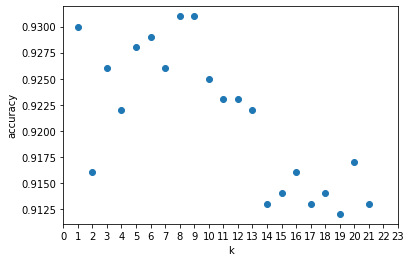

In [29]:
k_range = range(1,22)
scores = []

for k in k_range:
    acc = knn_pca_exp(k,-1,X_train,X_val,y_train,y_val)
    scores.append(acc)

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
print("Accuracy: {}".format(acc))
